In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
dfs=sns.load_dataset('diamonds')

In [ ]:
dfs

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [ ]:
dfs.isnull().sum()

,0
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


In [ ]:
dfs.duplicated().sum()

np.int64(146)

In [ ]:
dfs.drop_duplicates(inplace=True)

In [ ]:
dfs.dtypes

,0
carat,float64
cut,category
color,category
clarity,category
depth,float64
table,float64
price,int64
x,float64
y,float64
z,float64


In [ ]:
numeric_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

outlier_counts = {}

for col in numeric_cols:
    Q1 = dfs[col].quantile(0.25)
    Q3 = dfs[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dfs[(dfs[col] < lower_bound) | (dfs[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

dfs.shape

carat: 1873 outliers
depth: 2525 outliers
table: 604 outliers
price: 3523 outliers
x: 31 outliers
y: 28 outliers
z: 48 outliers


(53794, 10)

In [ ]:
def remove_outliers_zscore(dfs, column, threshold=3):
    mean = dfs[column].mean()
    std = dfs[column].std()
    z_scores = (dfs[column] - mean) / std
    df = dfs[(z_scores < threshold) & (z_scores > -threshold)].copy()
    return df
df=dfs.copy()
for col in numeric_cols:
    df = remove_outliers_zscore(df, col)

df.shape

(51051, 10)

In [ ]:
df['cut'].unique()

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

In [ ]:
df['color'].unique()

['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']

In [ ]:
df['clarity'].unique()

['SI2', 'SI1', 'VS2', 'VVS2', 'VVS1', 'VS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']

In [ ]:
df['depth'].unique()

array([61.5, 59.8, 62.4, 63.3, 62.8, 62.3, 61.9, 65.1, 59.4, 64. , 60.4,
       62.2, 60.2, 60.9, 62. , 63.4, 63.8, 62.7, 61. , 58.1, 62.5, 60.5,
       60. , 60.7, 59.5, 58.2, 64.1, 60.8, 61.8, 61.2, 61.1, 65.2, 58.4,
       63.1, 61.6, 59.3, 62.6, 63. , 63.2, 62.1, 61.4, 62.9, 63.7, 59.2,
       59.9, 57.9, 57.5, 61.7, 58.8, 64.5, 65.3, 59.6, 64.4, 65.7, 63.6,
       61.3, 60.1, 60.3, 58. , 64.6, 59.7, 57.8, 60.6, 64.2, 65.8, 63.5,
       63.9, 58.6, 64.3, 58.5, 65. , 58.3, 64.9, 59.1, 59. , 58.9, 58.7,
       57.7, 65.4, 65.5, 66. , 57.6, 65.6, 64.8, 64.7, 65.9])

In [ ]:
min_value = df['depth'].min()
max_value = df['depth'].max()
value_range = max_value - min_value

print(f"Minimum value in 'depth': {min_value}")
print(f"Maximum value in 'depth': {max_value}")
print(f"Range of values in 'depth': {value_range}")

Minimum value in 'depth': 57.5
Maximum value in 'depth': 66.0
Range of values in 'depth': 8.5


In [ ]:
df['carat'].unique()

array([0.23, 0.21, 0.29, 0.31, 0.24, 0.26, 0.22, 0.3 , 0.2 , 0.32, 0.33,
       0.25, 0.35, 0.42, 0.28, 0.38, 0.7 , 0.71, 0.78, 0.73, 0.8 , 0.75,
       0.74, 0.81, 0.59, 0.9 , 0.91, 0.61, 0.77, 0.63, 0.76, 0.64, 0.72,
       0.79, 0.58, 1.17, 0.6 , 0.83, 0.54, 0.52, 1.01, 0.51, 1.05, 0.55,
       0.87, 1.  , 0.57, 0.82, 0.96, 1.04, 0.53, 0.93, 1.2 , 0.34, 0.43,
       0.36, 0.84, 0.89, 1.02, 0.86, 0.97, 0.56, 0.85, 0.92, 1.27, 0.66,
       1.12, 0.68, 1.03, 0.62, 1.22, 0.95, 1.08, 0.5 , 1.19, 0.98, 0.39,
       0.65, 1.24, 1.5 , 0.27, 0.41, 1.13, 1.06, 0.69, 0.88, 0.4 , 1.14,
       0.94, 1.29, 1.23, 0.67, 1.11, 1.1 , 1.18, 1.15, 1.25, 1.07, 1.28,
       1.21, 1.09, 1.51, 1.52, 1.16, 0.37, 1.31, 1.26, 1.39, 0.99, 1.44,
       1.35, 1.3 , 1.32, 1.41, 1.34, 1.58, 1.54, 1.36, 1.38, 1.33, 1.74,
       1.64, 1.4 , 1.55, 1.95, 2.  , 1.37, 1.62, 1.57, 1.69, 2.06, 1.66,
       1.49, 1.46, 2.15, 1.7 , 1.53, 1.85, 1.68, 1.56, 2.03, 1.73, 1.59,
       1.42, 1.43, 1.47, 2.08, 1.48, 1.6 , 1.83, 1.

In [ ]:
min_value = df['carat'].min()
max_value = df['carat'].max()
value_range = max_value - min_value

print(f"Minimum value in 'carat': {min_value}")
print(f"Maximum value in 'carat': {max_value}")
print(f"Range of values in 'carat': {value_range}")

Minimum value in 'carat': 0.2
Maximum value in 'carat': 2.21
Range of values in 'carat': 2.01


In [ ]:
df['table'].unique()

array([55. , 61. , 58. , 57. , 56. , 54. , 62. , 59. , 63. , 60. , 55.3,
       53. , 56.4, 60.5, 52. , 55.8, 54.4, 57.1, 53.6, 54.8, 54.2, 54.9,
       56.7, 53.9, 57.8, 54.1, 55.1, 51. , 58.1, 56.9, 56.5, 53.7, 60.7,
       56.2, 56.6, 56.1, 56.3, 57.2, 57.5, 60.9, 59.8, 62.3, 60.1, 55.9,
       62.2, 54.5, 55.7, 53.4, 54.7, 58.8, 59.4, 62.5, 54.3, 60.6, 55.2,
       58.6, 54.6, 62.6, 57.7, 56.8, 57.9, 60.3, 55.6, 59.5, 57.4, 62.4,
       60.4, 53.3, 60.2, 60.8, 58.5, 57.6, 59.9, 63.5, 57.3, 61.4, 58.3,
       55.4, 58.2, 53.5, 59.7, 55.5, 58.7, 53.8, 59.1, 53.2, 59.3, 61.1,
       51.6, 59.2, 58.4, 53.1, 52.8, 61.3, 61.2, 61.9, 61.8, 59.6, 61.5,
       58.9, 62.8, 52.4, 63.3, 61.7, 63.4, 62.1, 61.6])

In [ ]:
min_value = df['table'].min()
max_value = df['table'].max()
value_range = max_value - min_value

print(f"Minimum value in 'table': {min_value}")
print(f"Maximum value in 'table': {max_value}")
print(f"Range of values in 'table': {value_range}")

Minimum value in 'table': 51.0
Maximum value in 'table': 63.5
Range of values in 'table': 12.5


In [ ]:
df['price'].unique()

array([ 326,  334,  335, ..., 2753, 2755, 2756])

In [ ]:
min_value = df['price'].min()
max_value = df['price'].max()
value_range = max_value - min_value

print(f"Minimum value in 'price': {min_value}")
print(f"Maximum value in 'price': {max_value}")
print(f"Range of values in 'price': {value_range}")

Minimum value in 'price': 326
Maximum value in 'price': 15458
Range of values in 'price': 15132


In [ ]:
df['x'].unique()

array([3.95, 3.89, 4.2 , 4.34, 3.94, 4.07, 3.87, 4.  , 4.25, 3.93, 3.88,
       4.35, 3.79, 4.38, 4.31, 4.23, 4.21, 4.26, 3.85, 4.39, 4.44, 3.97,
       4.28, 3.96, 4.04, 4.01, 3.92, 4.06, 3.83, 4.29, 4.13, 4.49, 3.99,
       4.19, 4.24, 4.36, 4.33, 4.02, 4.45, 3.91, 4.3 , 4.43, 4.54, 4.78,
       4.15, 4.08, 4.03, 4.65, 4.22, 5.7 , 5.68, 5.81, 5.85, 5.71, 5.77,
       5.97, 5.8 , 6.  , 5.94, 5.87, 5.9 , 6.14, 5.38, 5.96, 6.16, 5.73,
       5.98, 5.72, 6.01, 5.64, 5.57, 5.63, 5.65, 6.09, 5.56, 6.11, 6.03,
       5.89, 5.69, 5.62, 5.88, 5.52, 5.74, 5.53, 5.78, 5.83, 5.66, 5.82,
       5.79, 5.92, 5.39, 5.33, 6.83, 5.41, 5.25, 5.24, 5.67, 5.61, 5.76,
       5.6 , 5.19, 5.84, 6.39, 5.14, 5.11, 5.54, 6.07, 6.29, 6.31, 6.49,
       5.28, 5.48, 5.55, 6.41, 6.02, 5.91, 6.17, 6.61, 5.34, 5.12, 6.19,
       5.43, 5.99, 5.95, 6.37, 5.93, 6.46, 6.45, 5.22, 5.75, 6.21, 6.15,
       6.73, 5.49, 4.37, 4.47, 4.41, 4.27, 4.85, 4.32, 4.48, 4.5 , 4.56,
       4.94, 4.09, 5.15, 6.3 , 5.86, 5.23, 6.08, 6.

In [ ]:
df['x'].value_counts()

,count
x,
4.37,443
4.34,434
4.33,428
4.38,425
4.32,422
...,...
8.54,1
3.76,1
3.74,1


In [ ]:
min_value = df['x'].min()
max_value = df['x'].max()
value_range = max_value - min_value

print(f"Minimum value in 'x': {min_value}")
print(f"Maximum value in 'x': {max_value}")
print(f"Range of values in 'x': {value_range}")

Minimum value in 'x': 3.73
Maximum value in 'x': 8.6
Range of values in 'x': 4.869999999999999


In [ ]:
df['y'].unique()

array([3.98, 3.84, 4.23, 4.35, 3.96, 4.11, 3.78, 4.05, 4.28, 3.9 , 4.37,
       3.75, 4.42, 4.34, 4.29, 4.26, 4.27, 4.3 , 3.92, 4.43, 4.47, 4.01,
       3.94, 3.97, 3.99, 4.03, 4.06, 4.08, 3.85, 4.31, 4.16, 4.51, 4.5 ,
       4.55, 4.02, 4.24, 4.38, 3.95, 4.48, 3.89, 3.88, 4.33, 4.32, 4.59,
       4.84, 4.22, 4.  , 4.25, 4.13, 4.09, 4.04, 4.12, 4.67, 5.72, 5.67,
       5.73, 5.85, 5.9 , 5.76, 5.78, 5.93, 5.75, 5.96, 5.79, 5.87, 5.8 ,
       5.81, 6.11, 5.43, 6.  , 5.84, 6.12, 5.82, 5.74, 5.94, 6.07, 5.69,
       5.83, 5.61, 5.53, 5.58, 5.59, 5.97, 6.09, 5.99, 5.86, 5.68, 5.65,
       5.55, 5.77, 5.91, 5.56, 5.89, 5.92, 6.03, 5.44, 5.37, 5.88, 6.9 ,
       5.62, 5.27, 5.26, 5.7 , 5.64, 5.63, 5.71, 5.51, 5.22, 6.36, 5.54,
       5.66, 5.18, 5.15, 6.1 , 6.21, 6.22, 6.45, 6.01, 5.3 , 5.41, 5.52,
       6.27, 6.05, 6.06, 6.13, 6.55, 5.35, 5.16, 6.25, 6.02, 5.46, 6.23,
       6.08, 5.95, 5.45, 6.41, 6.34, 5.25, 6.15, 6.19, 6.66, 4.36, 4.2 ,
       4.79, 4.57, 4.52, 4.53, 4.58, 5.  , 5.11, 6.

In [ ]:
df['y'].value_counts()

,count
y,
4.34,436
4.37,430
4.35,423
4.33,419
4.32,411
...,...
8.48,1
3.87,1
3.83,1


In [ ]:
min_value = df['y'].min()
max_value = df['y'].max()
value_range = max_value - min_value

print(f"Minimum value in 'y': {min_value}")
print(f"Maximum value in 'y': {max_value}")
print(f"Range of values in 'y': {value_range}")

Minimum value in 'y': 3.68
Maximum value in 'y': 8.53
Range of values in 'y': 4.85


In [ ]:
df['z'].unique()

array([2.43, 2.31, 2.63, 2.75, 2.48, 2.47, 2.53, 2.49, 2.39, 2.73, 2.46,
       2.33, 2.71, 2.27, 2.68, 2.7 , 2.66, 2.41, 2.62, 2.59, 2.67, 2.4 ,
       2.42, 2.44, 2.37, 2.52, 2.78, 2.76, 2.61, 2.65, 2.79, 2.54, 2.64,
       2.45, 2.72, 2.69, 2.96, 2.58, 2.51, 2.56, 2.55, 2.87, 3.57, 3.5 ,
       3.56, 3.72, 3.38, 3.4 , 3.66, 3.65, 3.58, 3.59, 3.63, 3.69, 3.61,
       3.6 , 3.35, 3.67, 3.62, 3.87, 3.68, 3.49, 3.47, 3.46, 3.7 , 3.32,
       3.93, 3.95, 3.64, 3.53, 3.37, 3.43, 3.51, 3.52, 3.54, 3.48, 3.55,
       3.33, 3.3 , 4.13, 3.79, 3.24, 3.23, 3.19, 3.94, 3.21, 3.75, 3.18,
       3.41, 4.03, 4.09, 3.22, 4.18, 3.76, 3.83, 3.31, 3.17, 3.74, 3.8 ,
       3.39, 3.88, 4.  , 3.98, 3.85, 3.78, 3.84, 4.33, 4.01, 3.45, 2.74,
       2.95, 2.8 , 2.77, 2.9 , 2.82, 3.77, 3.9 , 3.73, 4.08, 3.44, 3.34,
       3.86, 3.89, 3.96, 3.42, 3.71, 3.91, 3.2 , 3.1 , 3.97, 4.02, 4.2 ,
       4.11, 3.99, 4.23, 3.27, 3.92, 2.83, 2.81, 3.82, 3.81, 4.21, 4.29,
       3.26, 2.88, 2.5 , 4.14, 4.26, 4.12, 3.25, 4.

In [ ]:
df['z'].value_counts()

,count
z,
2.70,760
2.69,744
2.71,733
2.68,730
2.72,691
...,...
2.28,1
2.34,1
2.29,1


In [ ]:
min_value = df['z'].min()
max_value = df['z'].max()
value_range = max_value - min_value

print(f"Minimum value in 'z': {min_value}")
print(f"Maximum value in 'z': {max_value}")
print(f"Range of values in 'z': {value_range}")

Minimum value in 'z': 1.53
Maximum value in 'z': 5.3
Range of values in 'z': 3.7699999999999996


In [ ]:
df = pd.get_dummies(df, columns=['clarity', 'color', 'cut'])
y = df[[col for col in df.columns if col.startswith('cut_')]]
x = df.drop(columns=[col for col in df.columns if col.startswith('cut_')])

In [ ]:
y

,cut_Ideal,cut_Premium,cut_Very Good,cut_Good,cut_Fair
0,True,False,False,False,False
1,False,True,False,False,False
3,False,True,False,False,False
4,False,False,False,True,False
5,False,False,True,False,False
...,...,...,...,...,...
53935,True,False,False,False,False
53936,False,False,False,True,False
53937,False,False,True,False,False
53938,False,True,False,False,False


In [ ]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=42)

In [ ]:
x_train.shape

(40840, 22)

In [ ]:
y_train.shape

(40840, 5)

In [ ]:
x_test.shape

(10211, 22)

In [ ]:
x_train.shape

(40840, 22)

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from keras.optimizers.schedules import ExponentialDecay
lr_s=ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    decay_rate=0.4
)

In [ ]:
from keras.optimizers import Adam
adam_ls=Adam(learning_rate=lr_s)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
checkpoint=ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,verbose=1
)

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.87474, saving model to best_model.keras
511/511 - 4s - 8ms/step - accuracy: 0.5721 - loss: 1.0735 - val_accuracy: 0.6741 - val_loss: 0.8747
Epoch 2/50

Epoch 2: val_loss improved from 0.87474 to 0.79751, saving model to best_model.keras
511/511 - 2s - 3ms/step - accuracy: 0.6567 - loss: 0.8809 - val_accuracy: 0.7015 - val_loss: 0.7975
Epoch 3/50

Epoch 3: val_loss improved from 0.79751 to 0.77159, saving model to best_model.keras
511/511 - 1s - 3ms/step - accuracy: 0.6752 - loss: 0.8324 - val_accuracy: 0.7046 - val_loss: 0.7716
Epoch 4/50

Epoch 4: val_loss improved from 0.77159 to 0.75952, saving model to best_model.keras
511/511 - 3s - 5ms/step - accuracy: 0.6862 - loss: 0.8111 - val_accuracy: 0.7091 - val_loss: 0.7595
Epoch 5/50

Epoch 5: val_loss improved from 0.75952 to 0.75185, saving model to best_model.keras
511/511 - 3s - 5ms/step - accuracy: 0.6926 - loss: 0.7945 - val_accuracy: 0.7145 - val_loss: 0.7518
Epoch 6/50

Epoch 6

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7855 - loss: 0.5486
Test Loss: 0.5528
Test Accuracy: 0.7844


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,577 (135.07 KB)

 Trainable params: 11,525 (45.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,052 (90.05 KB)

In [ ]:
x_test.shape

(10211, 22)

In [ ]:
preds=model.predict(x_test)
preds

320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[4.3271247e-01, 7.5003705e-03, 5.4371071e-01, 1.6060701e-02,
        1.5694943e-05],
       [9.0040869e-01, 3.3900745e-03, 9.5708825e-02, 4.5602149e-04,
        3.6654812e-05],
       [1.7105278e-02, 3.0120274e-01, 5.8452308e-01, 9.4715476e-02,
        2.4533637e-03],
       ...,
       [8.9010274e-01, 5.3892601e-02, 5.5480264e-02, 4.2520021e-04,
        9.9173012e-05],
       [8.6385059e-01, 1.0089386e-02, 1.2396208e-01, 2.0119615e-03,
        8.5847772e-05],
       [1.6839881e-01, 1.4679442e-01, 6.8157667e-01, 3.2212599e-03,
        8.8336110e-06]], dtype=float32)

In [ ]:
preds.shape

(10211, 5)

In [ ]:
preds.max(axis=1)

array([0.5437107 , 0.9004087 , 0.5845231 , ..., 0.89010274, 0.8638506 ,
       0.68157667], dtype=float32)

In [ ]:
pred_cls=np.argmax(preds,axis=1)
pred_cls

array([2, 0, 2, ..., 0, 0, 2])

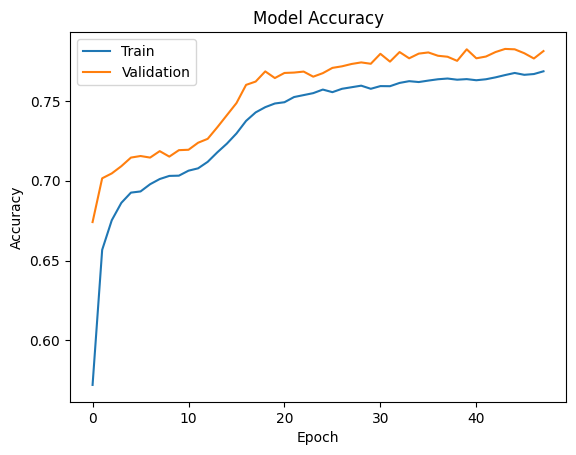

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

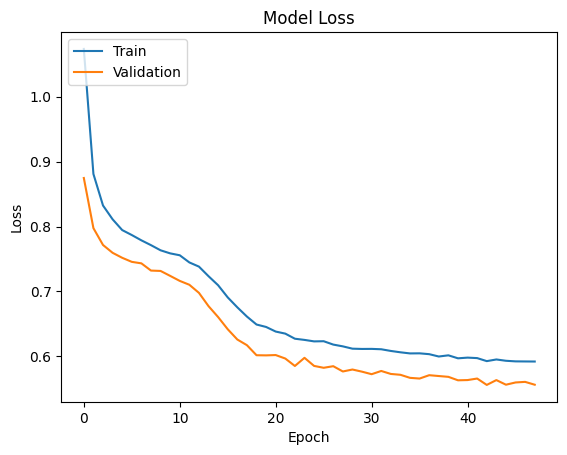

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()